<a href="https://colab.research.google.com/github/jiayi-ji01/Mechanistic-Multilingual-LLM/blob/main/ex02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import login
login()

In [ ]:
!pip install -U bitsandbytes

In [ ]:
import csv
import random
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


In [ ]:


CSV_PATH = "en_fr_de_it_zh_candidates.csv"
MODEL_ID = "CohereLabs/aya-expanse-8b"
USE_4BIT = True
DEVICE_MAP = "auto"
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.set_grad_enabled(False)


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map=DEVICE_MAP,
    trust_remote_code=True,
    quantization_config=bnb_config
)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

CohereForCausalLM(
  (model): CohereModel(
    (embed_tokens): Embedding(256000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x CohereDecoderLayer(
        (self_attn): CohereAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): CohereMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): CohereLayerNorm()
      )
    )
    (norm): CohereLayerNorm()
    (rotary_emb): CohereRotaryEmbedding()
  )
  (lm_h

## Task 1: Prompt Construction


In [ ]:
# create csv
data = [
    ["house", "maison", "Haus", "casa", "房子"],
    ["cat", "chat", "Katze", "gatto", "猫"],
    ["book", "livre", "Buch", "libro", "书"],
    ["lemon", "citron", "Zitrone", "limone", "柠檬"],
    ["water", "eau", "Wasser", "acqua", "水"],
    ["fire", "feu", "Feuer", "fuoco", "火"],
    ["tree", "arbre", "Baum", "albero", "树"],
    ["car", "voiture", "Auto", "macchina", "车"],
    ["sun", "soleil", "Sonne", "sole", "太阳"],
    ["moon", "lune", "Mond", "luna", "月亮"],
    ["dog", "chien", "Hund", "cane", "狗"],
    ["milk", "lait", "Milch", "latte", "牛奶"],
    ["bread", "pain", "Brot", "pane", "面包"],
    ["rain", "pluie", "Regen", "pioggia", "雨"],
    ["gold", "or", "Gold", "oro", "金子"]
]

df = pd.DataFrame(data, columns=["en", "fr", "de", "it", "zh"])
csv_path = "./en_fr_de_it_zh_candidates.csv"
df.to_csv(csv_path, index=False)


In [ ]:
def get_prompt_de_it(concept_de):
    """Source Task: German -> Italian"""
    return (
        'Deutsch: "Haus" - Italiano: "casa"\n'
        'Deutsch: "Katze" - Italiano: "gatto"\n'
        f'Deutsch: "{concept_de}" - Italiano: "'
    )

def get_prompt_fr_zh(concept_fr):
    """Target Task: French -> Chinese"""
    return (
        'Français: "maison" - 中⽂ : " 房⼦ "\n'
        'Français: "chat" - 中⽂ : " 猫 "\n'
        f'Français: "citron" - 中⽂ : "'
    )

## Task 2: Tokenization and Collision Detection

In [ ]:
def get_first_token_id(word):
    ids = tokenizer.encode(word, add_special_tokens=False)
    if len(ids) == 0: return None
    return ids[0]

def check_collisions(c_s_it, c_s_zh, c_t_it, c_t_zh):
    t1 = get_first_token_id(c_s_it)
    t2 = get_first_token_id(c_s_zh)
    t3 = get_first_token_id(c_t_it)
    t4 = get_first_token_id(c_t_zh)

    if None in [t1, t2, t3, t4]:
        return False

    tokens = [t1, t2, t3, t4]
    return len(set(tokens)) == 4

## Task 3：Activation Extraction & Patching

In [ ]:
# Creates a forward hook to patch activation at a specific position
def get_activation_hook(position_idx, activation_to_patch):

    def hook_fn(module, input, output):

        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output

        hidden_states[:, position_idx, :] = activation_to_patch.to(hidden_states.dtype)

        if isinstance(output, tuple):
            return (hidden_states,) + output[1:]
        return hidden_states

    return hook_fn

## Task 4: Probability Tracking and Experiment Execution

In [ ]:
# load data from csv
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"Error: {CSV_PATH} not found.")

concepts = df.to_dict('records')
results = []
valid_pairs = []

# sampling
samling_num = 3
for _ in range(samling_num):
    src = random.choice(concepts)
    tgt = random.choice(concepts)

    if src['de'] == tgt['de']:
        continue

    c_s_it = src["it"]
    c_s_zh = src["zh"]
    c_t_it = tgt["it"]
    c_t_zh = tgt["zh"]

    if check_collisions(c_s_it, c_s_zh, c_t_it, c_t_zh):

            valid_pairs.append({
                'src': src,
                'tgt': tgt,
                'tokens': {
                    'S_IT': get_first_token_id(c_s_it),
                    'S_ZH': get_first_token_id(c_s_zh),
                    'T_IT': get_first_token_id(c_t_it),
                    'T_ZH': get_first_token_id(c_t_zh),
                }
            })

print(valid_pairs)
print(f"Found {len(valid_pairs)} valid pairs.")

# patching
layers = range(model.config.num_hidden_layers)
for pair in tqdm(valid_pairs, desc="Processing Pairs"):

    concept_src = pair["src"]
    concept_tgt = pair["tgt"]
    # build prompts
    prompt_src = get_prompt_de_it(concept_src["de"])
    prompt_tgt = get_prompt_fr_zh(concept_tgt["fr"])
    # tokenize
    inputs_src = tokenizer(prompt_src, return_tensors="pt").to(model.device)
    inputs_tgt = tokenizer(prompt_tgt, return_tensors="pt").to(model.device)
    # last token position
    last_pos_src = inputs_src.input_ids.shape[1] - 1
    last_pos_tgt = inputs_tgt.input_ids.shape[1] - 1

    # source forward pass -> get hidden states
    with torch.no_grad():
        outputs_src = model(**inputs_src, output_hidden_states=True)
    hidden_states_src = outputs_src.hidden_states

    for layer_idx in layers:
        act_to_patch = hidden_states_src[layer_idx + 1][:, last_pos_src, :]
        #register hook
        layer_module = model.model.layers[layer_idx]
        hook_handle = layer_module.register_forward_hook(get_activation_hook(last_pos_tgt, act_to_patch))

        try:
            with torch.no_grad():
                outputs_tgt = model(**inputs_tgt)

            logits = outputs_tgt.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)[0]

            # extract prob.
            p_s_it = probs[pair['tokens']['S_IT']].item()
            p_s_zh = probs[pair['tokens']['S_ZH']].item()
            p_t_it = probs[pair['tokens']['T_IT']].item()
            p_t_zh = probs[pair['tokens']['T_ZH']].item()

            results.append({
                'layer': layer_idx,
                'src_concept': concept_src['de'],
                'tgt_concept': concept_tgt['fr'],
                'prob_S_IT': p_s_it,
                'prob_S_ZH': p_s_zh,
                'prob_T_IT': p_t_zh,
                'prob_T_ZH': p_t_zh,
            })

        finally:
            hook_handle.remove()

# save
df_results = pd.DataFrame(results)
df_results.to_csv("patching_results.csv", index=False)

[{'src': {'en': 'lemon', 'fr': 'citron', 'de': 'Zitrone', 'it': 'limone', 'zh': '柠檬'}, 'tgt': {'en': 'milk', 'fr': 'lait', 'de': 'Milch', 'it': 'latte', 'zh': '牛奶'}, 'tokens': {'S_IT': 7483, 'S_ZH': 5624, 'T_IT': 9680, 'T_ZH': 23687}}, {'src': {'en': 'dog', 'fr': 'chien', 'de': 'Hund', 'it': 'cane', 'zh': '狗'}, 'tgt': {'en': 'milk', 'fr': 'lait', 'de': 'Milch', 'it': 'latte', 'zh': '牛奶'}, 'tokens': {'S_IT': 61597, 'S_ZH': 62090, 'T_IT': 9680, 'T_ZH': 23687}}, {'src': {'en': 'sun', 'fr': 'soleil', 'de': 'Sonne', 'it': 'sole', 'zh': '太阳'}, 'tgt': {'en': 'tree', 'fr': 'arbre', 'de': 'Baum', 'it': 'albero', 'zh': '树'}, 'tokens': {'S_IT': 9483, 'S_ZH': 50831, 'T_IT': 242737, 'T_ZH': 30449}}]
Found 3 valid pairs.


Processing Pairs: 100%|██████████| 3/3 [00:23<00:00,  7.67s/it]


In [ ]:
results

[{'layer': 0,
  'src_concept': 'Hund',
  'tgt_concept': 'lait',
  'prob_S_IT': 0.0,
  'prob_S_ZH': 1.1920928955078125e-07,
  'prob_T_IT': 6.9141387939453125e-06,
  'prob_T_ZH': 6.9141387939453125e-06},
 {'layer': 1,
  'src_concept': 'Hund',
  'tgt_concept': 'lait',
  'prob_S_IT': 0.0,
  'prob_S_ZH': 1.1920928955078125e-07,
  'prob_T_IT': 9.47713851928711e-06,
  'prob_T_ZH': 9.47713851928711e-06},
 {'layer': 2,
  'src_concept': 'Hund',
  'tgt_concept': 'lait',
  'prob_S_IT': 5.960464477539063e-08,
  'prob_S_ZH': 1.7881393432617188e-07,
  'prob_T_IT': 1.1682510375976562e-05,
  'prob_T_ZH': 1.1682510375976562e-05},
 {'layer': 3,
  'src_concept': 'Hund',
  'tgt_concept': 'lait',
  'prob_S_IT': 5.960464477539063e-08,
  'prob_S_ZH': 1.7881393432617188e-07,
  'prob_T_IT': 1.4007091522216797e-05,
  'prob_T_ZH': 1.4007091522216797e-05},
 {'layer': 4,
  'src_concept': 'Hund',
  'tgt_concept': 'lait',
  'prob_S_IT': 5.960464477539063e-08,
  'prob_S_ZH': 1.7881393432617188e-07,
  'prob_T_IT': 1.57

## Task 5: Analysis

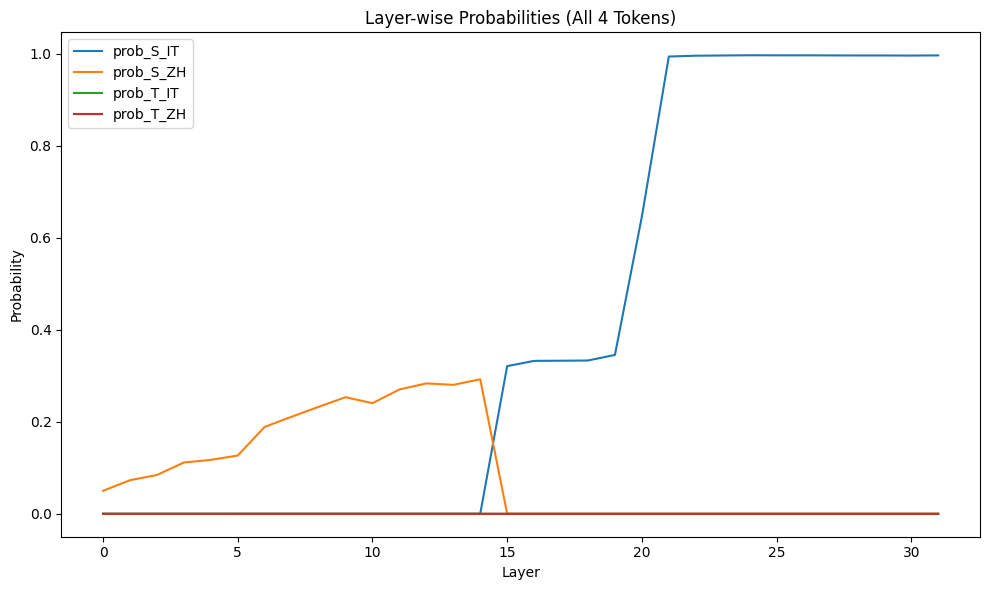

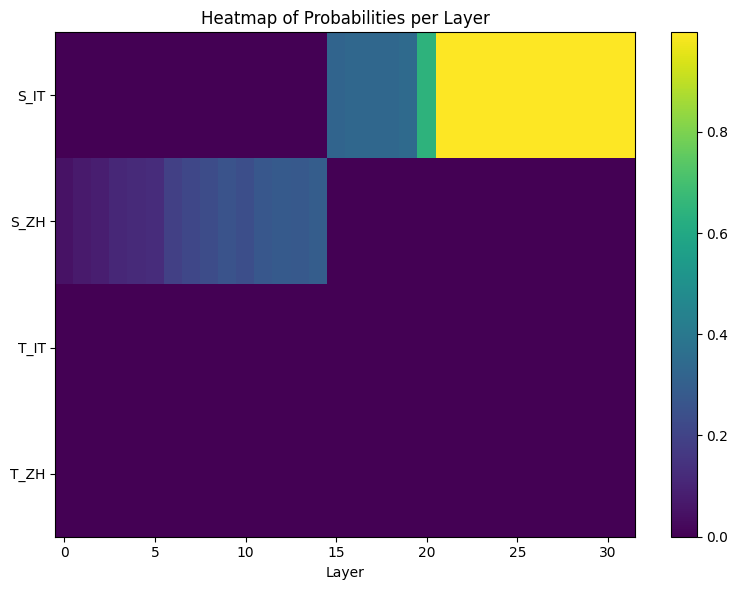

In [ ]:
# plot
RES_CVS = "patching_results.csv"
df_res = pd.read_csv(RES_CVS)

layer_stats = df_res.groupby("layer")[["prob_S_IT","prob_S_ZH","prob_T_IT","prob_T_ZH"]].mean()

plt.figure(figsize=(10,6))
for col in layer_stats.columns:
    plt.plot(layer_stats.index, layer_stats[col], label=col)

# Layer-wise Probabilities
plt.xlabel("Layer")
plt.ylabel("Probability")
plt.title("Layer-wise Probabilities (All 4 Tokens)")
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(8,6))
data = layer_stats.values.T  # shape (4, n_layers)
plt.imshow(data, aspect='auto')
plt.yticks(range(4), ["S_IT","S_ZH","T_IT","T_ZH"])
plt.xlabel("Layer")
plt.title("Heatmap of Probabilities per Layer")
plt.colorbar()
plt.tight_layout()
plt.show()

**1. When does the language switch occur?**

  The language switch ocurrs around layer 20-21. At this depth, prob_S_IT (the Italian translation of the source concept) abruptly increases from 0 to nearly 1.

  This sharp jump indicates that the patched activations from the DE→IT source prompt begin to strongly influence the model’s output language.All earlier layers produce ≈ 0 probability for S_IT, meaning no language-switching happens before layer 20.

  Thus, the language switch happens at the transition **between mid-layers and late-layers**.


  **2. When does the concept switch occur?**

  In the earliest layers, the model does not show any stable translational behavior.One notable observation is that prob_S_ZH gradually increases during layers 0–13. but, this signal is unstable: it drops abruptly to zero at layer 14-15, and when the number of sampled concept pairs increases, this effect becomes weaker and often vanishes.

  A similar phenomenon occurs with prob_T_ZH, which occasionally shows small non-zero spikes in early layers, but these values remain extremely low and vanish once sampling increases.

  prob_T_IT and prob_T_ZH remain at zero for all layers, indicating that the model never predicts the target concept in either language.

  The model performs a language switch  but never a concept switch.

## Task 6: Reflection

At the beginning, i was confused about the meaning behind the four terms: c_s_it, c_s_zh, c_t_it, and c_t_zh. I mix “concept” and “language” information, and I kept forgetting which ones were source or target concepts and which languages they referred to. I had to rethink their roles every time I saw them, which made me realize that understanding the semantic structure behind these symbols is more important than remembering the names themselves.

I also noticed that the results are very sensitive to the choice of candidate words. Different randomly sampled concept pairs can lead to noticeably different curves, especially when the sample size is small. This made me realize that interpretability experiments can easily be misleading if we rely on only a few examples, and that we need multiple samples to see stable patterns.

And when I only looked at the sample=1 case, I was easily drawn to some high probability spikes and almost interpreted them as meaningful behavior. But when I increased the sample size and averaged the results, most of those spikes disappeared. This made it clear that single-sample activations are often noise rather than real mechanisms, and it taught me to be more cautious when interpreting these visualizations.